In [1]:
import sys
import os

sys.path.append(os.path.abspath('..'))

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, auc, \
    roc_curve, RocCurveDisplay

In [3]:
from NN_utils.Layers.Linear import Linear
from NN_utils.Activations.Sigmoid import Sigmoid
from NN_utils.NeuralNetwork import NeuralNetwork
from NN_utils.Losses.MSE import MSE

In [4]:
plt.rcParams["figure.figsize"] = (19, 5)
# plt.style.use("seaborn-v0_8")

seed = 20
rng = np.random.default_rng(seed)

In [5]:
data = pd.read_csv("../data/prepared_data.csv")

In [6]:
data.head()

,class-label,cap-surface,cap-color,bruises,odor,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,ring-number,ring-type,spore-print-color,population,habitat
0,0,3,8,0,0,1,1,10,1,1,3,3,7,7,1,4,6,4,6
1,0,3,8,0,0,1,1,10,1,1,3,3,7,7,1,4,1,4,6
2,0,3,8,0,0,1,1,7,1,1,3,3,7,7,1,4,6,4,6
3,0,3,8,0,0,1,1,7,1,1,3,3,7,7,1,4,1,4,6
4,0,3,8,0,0,1,1,1,1,1,3,3,7,7,1,4,6,4,6


In [7]:
data.shape

(8416, 19)

In [8]:
X = data.iloc[:, 1:].to_numpy()
y = data.iloc[:, :1].to_numpy()

In [9]:
X.shape

(8416, 18)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

In [11]:
print(y_train.shape, y_test.shape)

(5891, 1) (2525, 1)


## Building model

In [12]:
MLP = NeuralNetwork()

MLP.add(Linear(in_neurons=18, out_neurons=10, random_seed=seed))
MLP.add(Sigmoid())
MLP.add(Linear(in_neurons=10, out_neurons=5, random_seed=seed))
MLP.add(Sigmoid())
MLP.add(Linear(in_neurons=5, out_neurons=2, random_seed=seed))
MLP.add(Sigmoid())

In [13]:
loss = MSE()

## Train function

In [14]:
def train(model: NeuralNetwork, X: np.ndarray, y: np.ndarray, loss_function, epochs: int = 100,
          lr: float = 1e-3) -> np.ndarray:
    epoch_losses = np.array([])
    one_hot_matrix = np.eye(np.unique(y).shape[0])

    dataset = list(zip(X, y))
    dataset_size = X.shape[0]
    for epoch in range(epochs):
        rng.shuffle(dataset)
        loss_value = 0
        for X_curr, y_curr in tqdm(dataset):
            y_pred = model.feedforward(X_curr.reshape(-1, 1))
            y_true = one_hot_matrix[y_curr].reshape(-1, 1)

            loss_value += loss_function.fn(y_true, y_pred)
            delta = loss_function.dfn(y_true, y_pred)
            model.backprop(delta, lr)

        loss_value /= dataset_size
        epoch_losses = np.append(epoch_losses, loss_value)

    return epoch_losses

## Predict function

In [15]:
def predict(model: NeuralNetwork, X: np.ndarray) -> np.ndarray:
    y_preds = np.array([])
    for i in range(X.shape[0]):
        y_preds = np.append(y_preds, np.argmax(model.feedforward(X[i].reshape(-1, 1))))
    return y_preds

# Training model

In [16]:
epoch_losses = train(model=MLP, X=X_train, y=y_train, loss_function=loss, epochs=30, lr=1e-2)

100%|██████████| 5891/5891 [00:01<00:00, 4916.46it/s]


First epoch loss - 0.23022557526309714
Last epoch loss - 0.005073420550768666


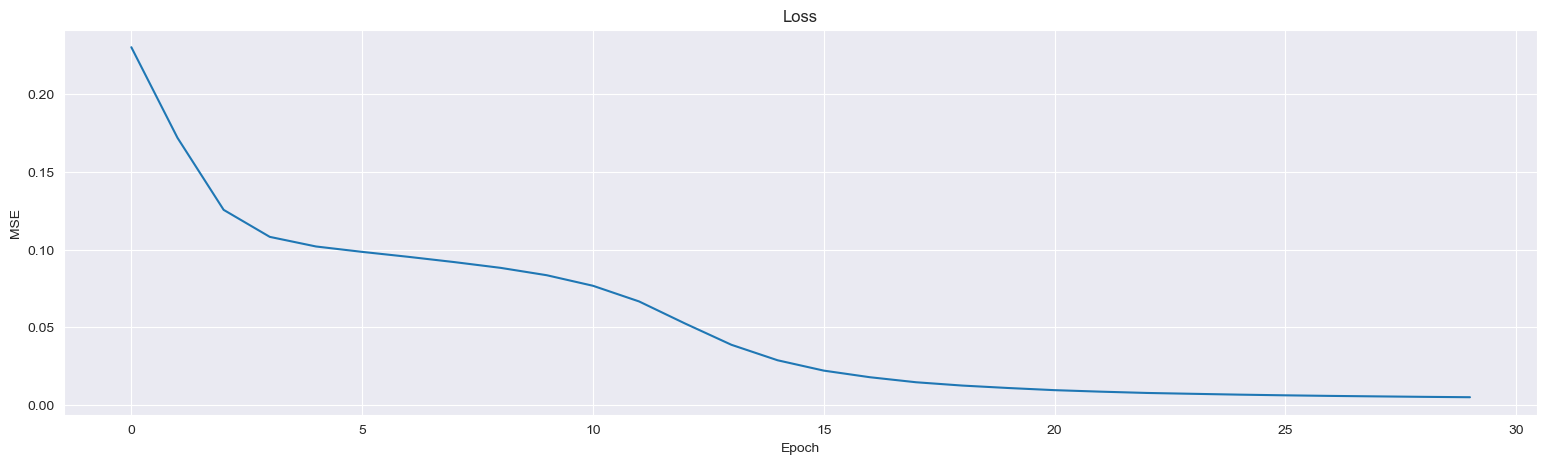

In [17]:
plt.plot(epoch_losses)
plt.title("Loss")
plt.xlabel('Epoch')
plt.ylabel('MSE')
print(f"First epoch loss - {epoch_losses[0]}\nLast epoch loss - {epoch_losses[-1]}")

## Test results

In [18]:
y_pred = predict(MLP, X_test)

In [19]:
accuracy_score(y_true=y_test, y_pred=y_pred)

0.9972277227722772

In [20]:
print(classification_report(y_true=y_test, y_pred=y_pred, target_names=['EDIBLE', 'POISONOUS']))

              precision    recall  f1-score   support

      EDIBLE       1.00      1.00      1.00      1347
   POISONOUS       1.00      1.00      1.00      1178

    accuracy                           1.00      2525
   macro avg       1.00      1.00      1.00      2525
weighted avg       1.00      1.00      1.00      2525



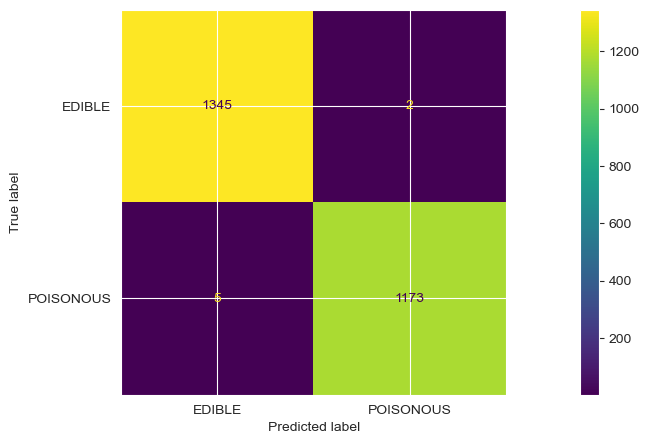

In [21]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['EDIBLE', 'POISONOUS']).plot()

In [22]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

Text(0, 0.5, 'True Positive Rate')

<Figure size 1900x500 with 0 Axes>

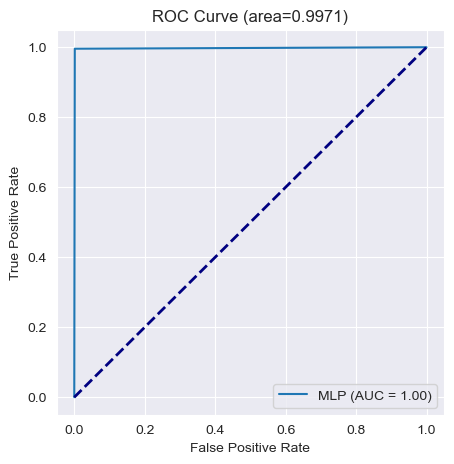

In [23]:
plt.figure()
plt.rcParams["figure.figsize"] = (5, 5)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='MLP').plot()
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title(f'ROC Curve (area={round(roc_auc,4)})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')